# CNN for Sentence Classification 논문 구현

#### Git - Commit Message Convention

* 제가 대략적으로 framework을 잡아놓은 것이니, 담당하시는 부분에 수정이 필요하시면 마크다운 양식만 유지한 채 수정해주시면 됩니다!
* 작은 단위의 작업이 끝날 때 마다 git add, commit, push 해주시면 됩니다! (push하고 슬랙에 공유 부탁드려요! 화이팅!)

* git commit message는 다음의 양식을 참고해주세요!
    * 처음으로 코드 완료했을 때 git commit -m "동사 명사"
    ```ex) git commit -m "Fill and replace NaN values"```
    
    * commit 했던 코드를 수정했을 때 git commit -m "Update 수정한 내용"
    ```ex) git commit -m "Update Word embedding"```


# 1. 데이터 load 및 EDA

## 1) 네이버 영화 리뷰 데이터 불러오기

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv("ratings_train.txt", sep='\t')
test = pd.read_csv("ratings_test.txt", sep='\t')

In [3]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
train.info()    #document에 null값 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [5]:
test.info()    #document에 null값 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [5]:
train[train['document'].isnull()]     #갯수가 별로 없고 대체할 방법이 없으므로 결측치 제거

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [6]:
## 결측치 제거
train.dropna(inplace=True)
test.dropna(inplace=True)

## 2) 리뷰 데이터 EDA

## 3) Sentences, labels 생성

In [31]:
import numpy as np

In [32]:
# sentence는 tokenize하고 생성
# label만 numpy로 생성
train_labels = np.array(train.label)
test_labels = np.array(test.label)

str

# 2. Data Preprocessing

## 1) Tokenizer

* 어절 단위
* 형태소 단위
* Subword 단위 중 선택

In [34]:
# 영어, 한글만 포함하고 나머지 제거
import re

def preprocess(text):
  text = re.sub(r"[^A-Za-zㄱ-ㅎㅏ-ㅣ가-힣 ]","", text) 
  return text

train['document'] = train.document.apply(lambda x : preprocess(x))
test['document'] = test.document.apply(lambda x : preprocess(x))

train.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [36]:
# Mecab으로 형태소 분석, 불용어 제거
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

train_tokens = []
test_tokens = []

for sentence in train['document']:
    tokenized_sentence = tokenizer.morphs(sentence) 
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] 
    train_tokens.append(stopwords_removed_sentence)

for sentence in test['document']:
    tokenized_sentence = tokenizer.morphs(sentence) 
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] 
    test_tokens.append(stopwords_removed_sentence)

In [39]:
train_tokens[:10]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다'],
 ['교도소', '이야기', '구먼', '솔직히', '재미', '없', '다', '평점', '조정'],
 ['사이몬페그',
  '익살',
  '스런',
  '연기',
  '돋보였',
  '던',
  '영화',
  '스파이더맨',
  '에서',
  '늙',
  '어',
  '보이',
  '기',
  '만',
  '했',
  '던',
  '커스틴',
  '던스트',
  '너무나',
  '이뻐',
  '보였',
  '다'],
 ['막',
  '걸음마',
  '뗀',
  '세',
  '부터',
  '초등',
  '학교',
  '학년',
  '생',
  '인',
  '살용',
  '영화',
  'ㅋㅋㅋ',
  '별반',
  '개',
  '아까움'],
 ['원작', '긴장감', '을', '제대로', '살려', '내', '지', '못했', '다'],
 ['별',
  '반개',
  '아깝',
  '다',
  '욕',
  '나온다',
  '이응경',
  '길용우',
  '연기',
  '생활',
  '몇',
  '년',
  '인지',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫',
  '겟',
  '다',
  '납치',
  '감금',
  '만',
  '반복',
  '반복',
  '드라마',
  '가족',
  '없',
  '다',
  '연기',
  '못',
  '하',
  '사람',
  '만',
  '모엿',
  '네'],
 ['액션', '없', '는데', '재미', '있', '몇', '안', '되', '영화'],
 ['왜',
  '케',
  '평점',
  '낮',
  '건데',
  '꽤',
  '볼',
  '만',
  '한데',
  '헐리우드',
  '식

In [38]:
test_tokens[:3]

[['굳', 'ㅋ'],
 ['GDNTOPCLASSINTHECLUB'],
 ['뭐', '야', '평점', '나쁘', '진', '않', '지만', '점', '짜리', '더더욱', '아니', '잖아']]

## 2) Word Vectorize

* word embedding : 문장들을 word vector 형태로 변환
    * 윗단에서 tokenizer output을 '문장' 형태라고 가정하고 코드 작업
    1. 문장을 토큰으로 쪼갠다
    2. 쪼개진 토큰을 가장 긴 문장에 맞춰 패딩한다
    3. 패딩이 마친 토큰들을 word vector로 변환하다
* oov, padding, truncating 확인

In [12]:
example_sentences = train.document[:10]
example_sentences

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
5        막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
6                                원작의 긴장감을 제대로 살려내지못했다.
7    별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...
8                               액션이 없는데도 재미 있는 몇안되는 영화
9        왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?
Name: document, dtype: object

In [21]:
len(example_sentences[0])

19

In [22]:
ex_sent_len = [len(sent) for sent in example_sentences]
ex_sent_len

[19, 33, 17, 29, 61, 45, 21, 86, 22, 45]

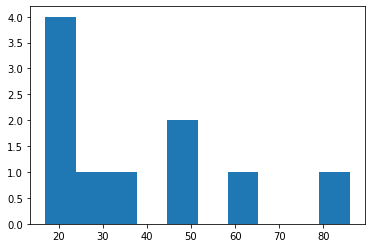

In [24]:
plt.hist(ex_sent_len)
plt.show()

In [25]:
max(ex_sent_len)

86

In [27]:
## 문장 평균 기리
sum(ex_sent_len)/len(ex_sent_len)

37.8

In [16]:
!python -m pip install tensorflow==2.3

  Using cached tensorflow-2.3.0-cp37-cp37m-win_amd64.whl (342.5 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached h5py-2.10.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached scipy-1.4.1-cp37-cp37m-win_amd64.whl (30.9 MB)
  Using cached grpcio-1.44.0-cp37-cp37m-win_amd64.whl (3.4 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
  Using cached google_auth-2.6.0-py2.py3-none-any.whl (156 kB)
  Using cached cachetools-5.0.0-py3-none-any.whl (9.1 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Attempting u

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.18.5 which is incompatible.
You should consider upgrading via the 'C:\Users\dhfps\anaconda3\envs\nlp\python.exe -m pip install --upgrade pip' command.


In [18]:
!C:\Users\dhfps\anaconda3\envs\nlp\python.exe -m pip install --upgrade pip

     ---------------------------------------- 2.1/2.1 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.2
    Uninstalling pip-22.0.2:
      Successfully uninstalled pip-22.0.2


In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
## vocabulary, sequences 생성 및 padding
oov_tok = '<oov>'
max_length = 40
trunc_type = 'post'

tokenizer = Tokenizer(oov_token="<oov>")    #Tokenizer 객체 생성
tokenizer.fit_on_texts(example_sentences)    #train sentences 입력
word_index = tokenizer.word_index           #word : index 사전(vocab) 생성
sequences = tokenizer.texts_to_sequences(example_sentences)     #시퀀스 생성
padded = pad_sequences(sequences, maxlen=max_length, padding=trunc_type, truncating='post')   #padding, truncating

In [38]:
index_word = {value : key for (key, value) in word_index.items()}    #index : word 사전

## 시퀀스 decoding 함수
def decode_review(text):
  return " ".join([index_word.get(i, '?') for i in text])

In [34]:
sequences[0]    # 첫 번째 시퀀스 확인

[3, 4, 5, 6, 7]

In [39]:
decode_review(padded[0])    # padded 된 시퀀스 -> decode해서 확인

'아 더빙 진짜 짜증나네요 목소리 ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?'

## 3) Train, Valid, Test set 생성

# 3. Convolutional Neural Networks Modeling

## 1) 기본 Model 생성

* Check points
* padding, initializer
* activation function
* Dropout
* Batch Normalization
* optimizer

## 2) Model 저장, Callback 설정

# 4. Final Results